In [35]:
# importando bibliotecas:
import numpy as np
import imageio as im
import math
import matplotlib.pyplot as plt
import cv2
import copy
import re

In [36]:
#####################################################################################################################
def correcao_gamma(image, gamma):
    return np.floor(255 * (((image)/255.0)**(1/gamma)))

In [37]:
#####################################################################################################################
def histogram(image, no_levels):

    hist = np.zeros(no_levels).astype(int)# Cria um histograma com o tamanho da quantidade de tons de cinza que no caso é 255

    for i in range(no_levels):# Para todos os tons de cinza
        pixels_value_i = np.sum(image == i)# Somatorio das posições cujo valor do pixel da imagem corresponde ao valor i
        hist[i] = pixels_value_i# Armazena no histograma


    histC = np.zeros(no_levels).astype(int)# Cria um novo histograma cumulativo

    # computes the cumulative histogram
    histC[0] = hist[0] # O primeiro valor é corresponde com o primeiro valor do histgrama
    for i in range(1,  no_levels):#Valores de 1 até no_levels que no caso é 255
        histC[i] = hist[i] + histC[i-1]# Para cada intensidade acumula com o valor anterior para obter o histograma
            
    return histC

In [38]:
#####################################################################################################################
def histogram_equalization(image, no_levels, histC):
    
    N, M = image.shape[0], image.shape[1]# O tamanho da imagem
    
    image_eq = np.zeros([N,M]).astype(np.uint8)# Cria uma matriz vazia para armazenar a imagem equalizada
    
    for z in range(no_levels):# Para cada valor de intensidade transforma em uma nova intensidade
        s = ((no_levels-1)/float(M*N))*histC[z]# Calcula qual o valor s baseado no valor do histograma cujo valor é z
        
        image_eq[ np.where(image == z) ] = s# Quando a coordenada da matriz corresponder com o valor da imagem coloca o valor s
    
    return image_eq

In [39]:
##################################################################################################################### 
def enhance_image(image):
    img_new = copy.copy(image)

    # Tratando os 3 canais da imagem
    image1 = image[:,:,0]
    image2 = image[:,:,1]
    image3 = image[:,:,2]
    
    # Aplicando o Histogram equalization:
    img_new1 = histogram_equalization(image1, 256, histogram(image1, 256))
    img_new2 = histogram_equalization(image2, 256, histogram(image2, 256))
    img_new3 = histogram_equalization(image3, 256, histogram(image3, 256))

    img_new[:,:,0] = img_new1
    img_new[:,:,1] = img_new2
    img_new[:,:,2] = img_new3

    return img_new

In [40]:
#####################################################################################################################
def enhance_image_gamma(image,gamma):
    img_new = copy.copy(image)
    
    #  Tratando os 3 canais da imagem
    image1 = image[:,:,0]
    image2 = image[:,:,1]
    image3 = image[:,:,2]
    
    # Aplicando a correlação gamma:
    img_new1 = correcao_gamma(image1, gamma).astype(np.uint8)
    img_new2 = correcao_gamma(image2, gamma).astype(np.uint8)
    img_new3 = correcao_gamma(image3, gamma).astype(np.uint8)

    img_new[:,:,0] = img_new1
    img_new[:,:,1] = img_new2
    img_new[:,:,2] = img_new3

    return img_new

In [41]:
##################################################################################################################### 
def coloring(image):

    # Carregando os modelos
    prototxt = 'modelos/colorization_deploy_v2.prototxt'
    model = 'modelos/colorization_release_v2.caffemodel'
    points = 'modelos/pts_in_hull.npy'

    # load our serialized black and white colorizer model and cluster
    # center points from disk
    print("[INFO] loading model...")
    net = cv2.dnn.readNetFromCaffe(prototxt, model)
    pts = np.load(points)
    
    # Add o centro do cluster como 1x1 convolutions para o modelo
    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
    
    # Carrega a imagem, escala os pixels de intesidade para o intervalo [0,1]
    # depois converte a imagem para o formato Lab color space.
    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
    
    # Redimensiona a imagem para 224x224, que é a dimensão que a rede aceita.
    # Depois separa os canais, extrai o canal L e por fim perfoma a média central:
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50
    
    # Passa o canal L para a network, onde irá predizer os possívels valores
    # dos canais 'a' e 'b':
    'print("[INFO] colorizing image...")'
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    
    # Redimensiona 'ab' para os mesmos valores da imagem de entrada:
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))
    
    # Seleciona o canal L da imagem de entrada e concatena com o canal 'ab' gerado pela rede
    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
    
    # Converte a nova imagem de Lab para RGB
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    # Retira os valores que não fazer parte do intervalo [0,1]
    colorized = np.clip(colorized, 0, 1)
    
    # Normaliza os valores para 255 e seta a imagem como uint8
    colorized = (255 * colorized).astype("uint8")

    # Retornando a imagem colorida
    return colorized

The_fountain.jpg
[INFO] loading model...
[INFO] loading model...
[INFO] loading model...
[INFO] loading model...


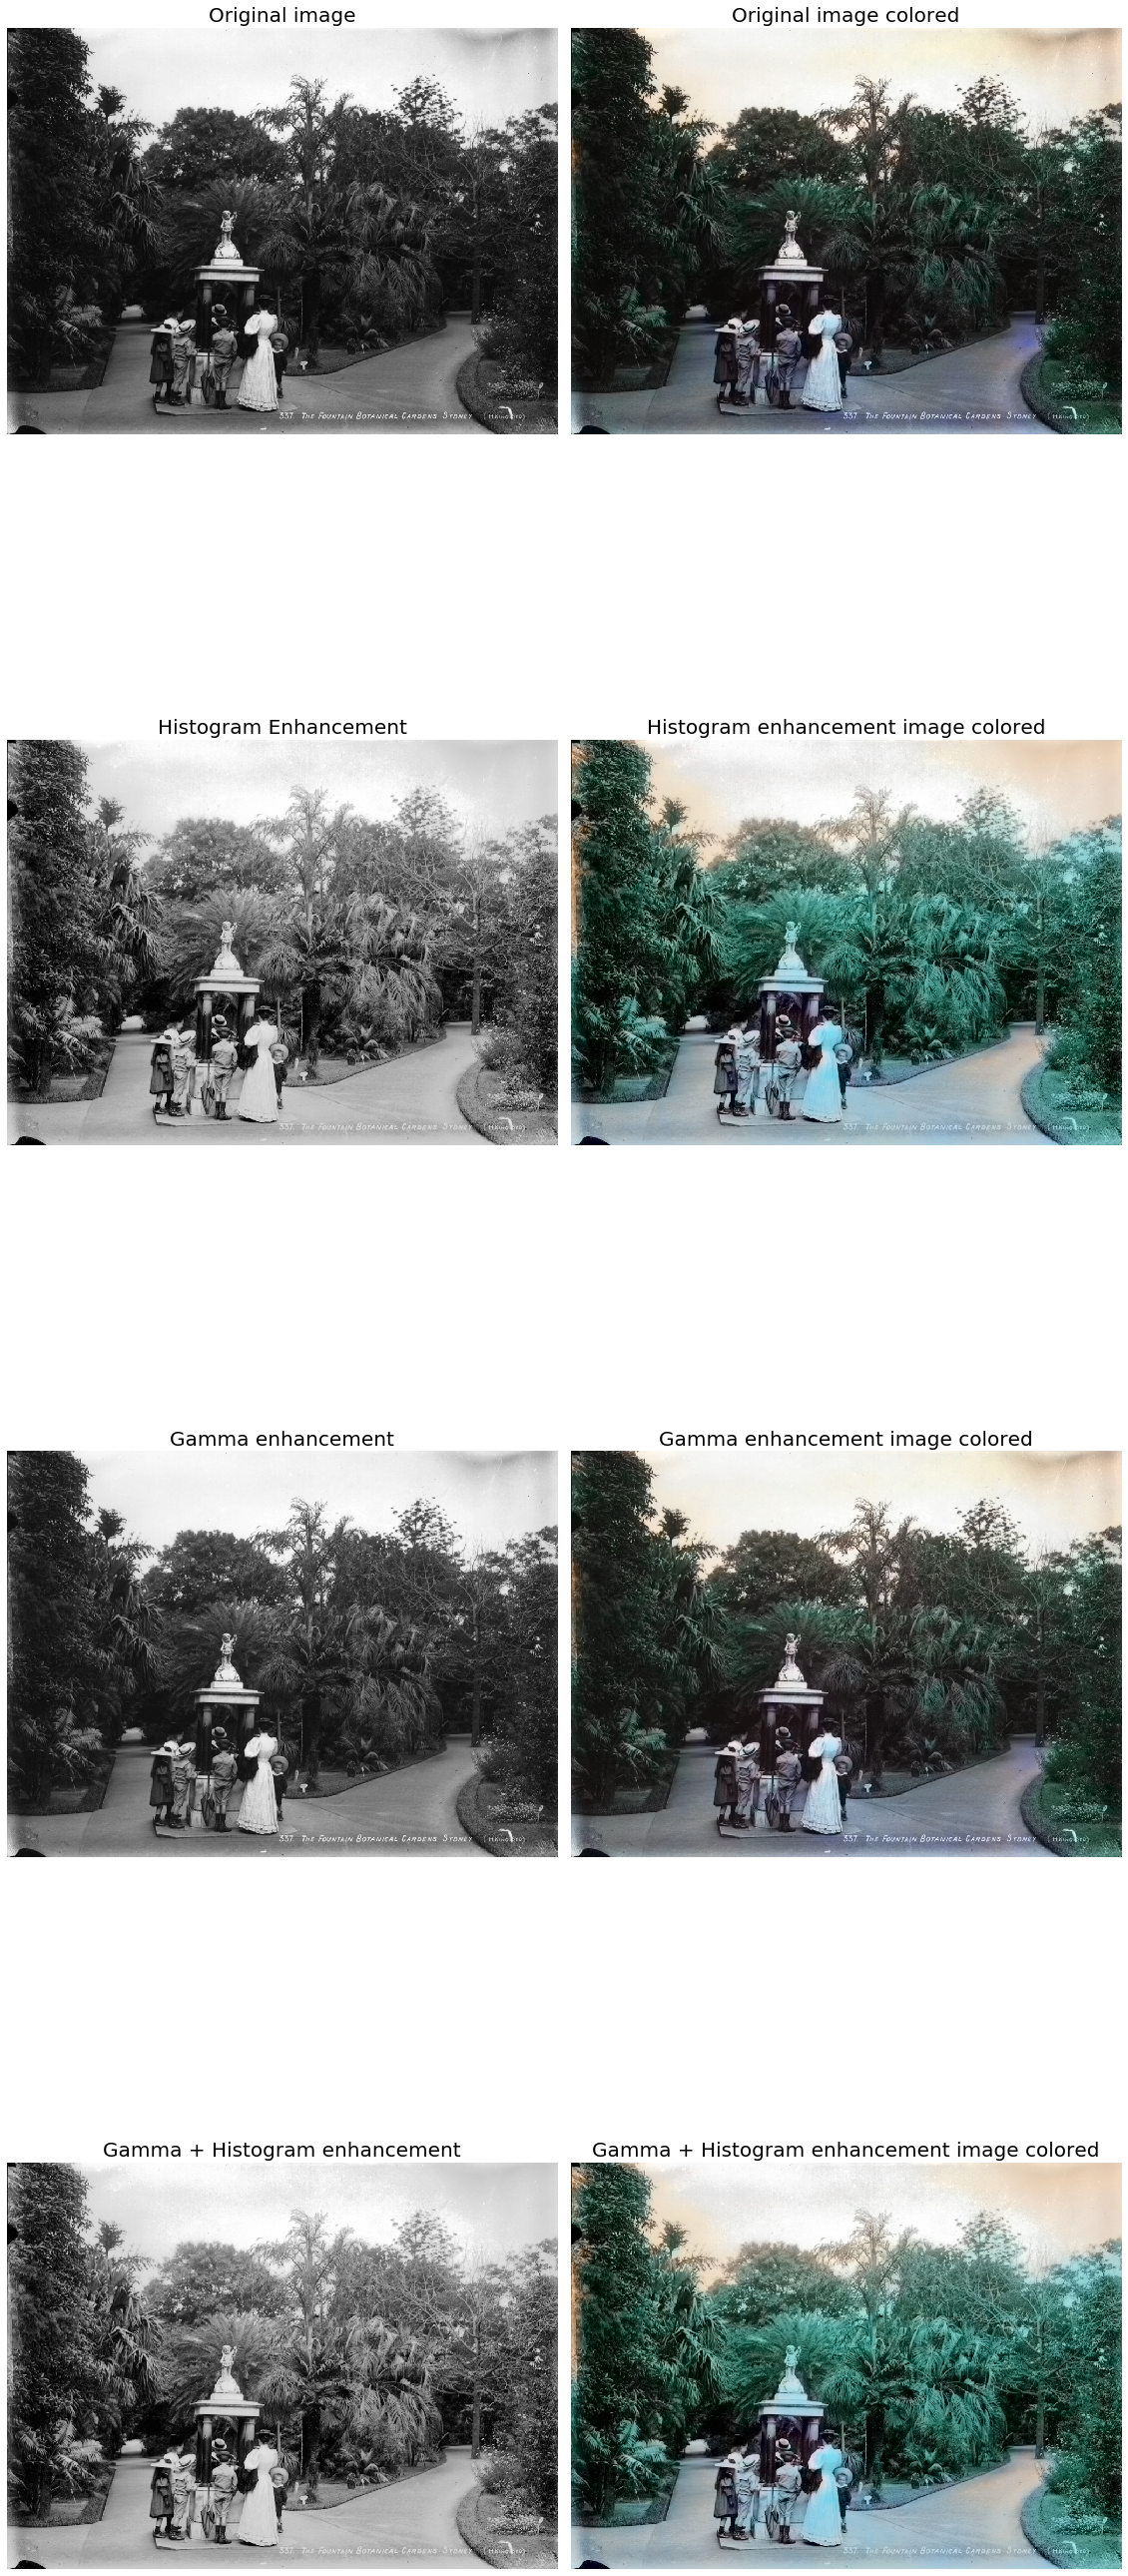

NameError: name 'image' is not defined

In [43]:
#####################################################################################################################  
def main():
    #Carregando a imagem
    filename = input().rstrip()
    filename = "bw_images/" + filename #Adicionando o repositório no nome
    gamma = 1.2
    
    original_image = cv2.imread(filename)
    color_image = coloring(original_image)
    
    image_hist = enhance_image(original_image)
    color_image_hist = coloring(image_hist)
    
    gamma_image = enhance_image_gamma(original_image,gamma)
    color_gamma_image = coloring(gamma_image)
    
    gamma_hist_image = enhance_image(gamma_image)
    color_gamma_hist_image = coloring(gamma_hist_image)
    
    
    plt.figure(figsize=(20,52))
    plt.subplots_adjust(wspace=0.025, hspace=0.035)
    
    # Original image
    plt.subplot(421)
    plt.imshow(original_image)
    plt.title("Original image", fontsize=20)
    plt.axis('off')
    
    # original image colored
    plt.subplot(422)
    plt.imshow(color_image)
    plt.title("Original image colored", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement
    plt.subplot(423)
    plt.imshow(image_hist)
    plt.title("Histogram Enhancement", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement colored
    plt.subplot(424)
    plt.imshow(color_image_hist)
    plt.title("Histogram enhancement image colored", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement
    plt.subplot(425)
    plt.imshow(gamma_image)
    plt.title("Gamma enhancement", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement colored
    plt.subplot(426)
    plt.imshow(color_gamma_image)
    plt.title("Gamma enhancement image colored", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement
    plt.subplot(427)
    plt.imshow(gamma_hist_image)
    plt.title("Gamma + Histogram enhancement", fontsize=20)
    plt.axis('off')
    
    # Original image enhancement colored
    plt.subplot(428)
    plt.imshow(color_gamma_hist_image)
    plt.title("Gamma + Histogram enhancement image colored", fontsize=20)
    plt.axis('off')
    
    plt.show()
    
    #Salvando as imagems geradas em um arquivo
    filename = re.split("\/", filename)[1] #Usando regex para extrair o nome da imagem.
    filename_hist = "resultados/hist_" + filename #Adicionando o repositório no nome
    filename_gamma = "resultados/gamma_" + filename 
    filename_gamma_hist = "resultados/gamma_hist" + filename 
    
    filename_color =  "resultados/color_" + filename
    filename_color_hist =  "resultados/color_hist_" + filename
    filename_color_gamma =  "resultados/color_gamma_" + filename
    filename_color_gamma_hist =  "resultados/color_gamma_hist_" + filename
    
    im.imwrite(filename_hist, image)
    im.imwrite(filename_gamma, image)
    im.imwrite(filename_gamma_hist, image)
    im.imwrite(filename_color, image)
    im.imwrite(filename_color_hist, image)
    im.imwrite(filename_color_gamma, image)
    im.imwrite(filename_color_gamma_hist, image)
    
main()